In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from tqdm import tqdm_notebook as tqdm
import pickle
from pathlib import Path
from nuscenes import NuScenes
from scipy.spatial.transform import Rotation as R 
from math import cos, sin, pi
from lyft_dataset_sdk.lyftdataset import *
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from second.pytorch.train import build_network, example_convert_to_torch

In [3]:
import torch
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool

In [5]:
phase = 'test'
data = 'v1.0-trainval' if phase=='train' else 'v1.0-test'
lyft = LyftDataset(data_path=f'../../data/lyft/{phase}/', json_path=f'../../data/lyft/{phase}/{data}/', verbose=0) 
# nusc = NuScenes(dataroot=f'../../data/lyft/{phase}/', version=data, verbose=0) 

## Read Config file

In [4]:
config_path = "configs/nuscenes/all.fhd.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
# config_tool.change_detection_range_v2(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Build Network, Target Assigner and Voxel Generator

In [17]:
ckpt_path = "/home/ags/second_test/all_fhd/voxelnet-29369.tckpt"
net = build_network(model_cfg).to(device).float().eval()
net.load_state_dict(torch.load(ckpt_path))
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator
classes = target_assigner.classes

[  41 1984 1984]


## Generate Anchors

In [18]:
grid_size = voxel_generator.grid_size
feature_map_size = grid_size[:2] // config_tool.get_downsample_factor(model_cfg)
feature_map_size = [*feature_map_size, 1][::-1]

anchors = target_assigner.generate_anchors(feature_map_size)["anchors"]
anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
anchors = anchors.view(1, -1, 7)

In [16]:
anchors.shape

torch.Size([1, 261392, 7])

### utility functions

In [7]:
def get_global_from_lidar(sample_token):
    sample_record = lyft.get("sample", sample_token) # get sample record
    lidar_record = lyft.get("sample_data", sample_record["data"]["LIDAR_TOP"])
    cs_record = lyft.get('calibrated_sensor', lidar_record['calibrated_sensor_token']) 
    ego_pose_record = lyft.get("ego_pose", lidar_record["ego_pose_token"])
    car_from_lidar = transform_matrix(cs_record['translation'], Quaternion(cs_record['rotation']), inverse=False)
    global_from_car = transform_matrix(ego_pose_record['translation'], Quaternion(ego_pose_record['rotation']), inverse=False)
    global_from_lidar = np.dot(global_from_car, car_from_lidar)
    return global_from_lidar

def transform_points(points, transf_matrix):
    """
    Transform (N, 3) or (N, 3) points using transformation matrix.
    """
    points = points.T
    points = np.vstack((points[:3, :], np.ones(points.shape[1])))  # 4xN
    new_points = transf_matrix.dot(points) # 4xN
    new_points = new_points[:3, :] # 3xN
    return new_points.T # Nx3

In [8]:
# info_path = input_cfg.dataset.kitti_info_path
# root_path = Path(input_cfg.dataset.kitti_root_path)
info_path = '../../data/lyft/test/infos_test.pkl'
root_path = '../../data/lyft/test/'
with open(info_path, 'rb') as f:
    infos = pickle.load(f)
df = pd.read_csv('../../data/lyft/sample_submission.csv')
# df = pd.read_csv('../../data/lyft/train.csv')

In [9]:
token2info = {}
for info in infos['infos']:
    token2info[info['token']] = info

In [23]:
def get_predictions(token):
    info = token2info[token]
    v_path = info["lidar_path"]
    points = np.fromfile(v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]
    res = voxel_generator.generate(points, max_voxels=90000)
    voxels, coords, num_points = res['voxels'], res['coordinates'], res['num_points_per_voxel']
    # add batch idx to coords
    coords = np.pad(coords, ((0, 0), (1, 0)), mode='constant', constant_values=0)
    voxels = torch.tensor(voxels, dtype=torch.float32, device=device)
    coords = torch.tensor(coords, dtype=torch.int32, device=device)
    num_points = torch.tensor(num_points, dtype=torch.int32, device=device)
    example = {
        "anchors": anchors,
        "voxels": voxels,
        "num_points": num_points,
        "coordinates": coords,
    }

#     example = example_convert_to_torch(example, device=device)
    pred = net(example)[0]
    pred['box3d_lidar'] = pred["box3d_lidar"].detach().cpu().numpy()
    pred['scores'] = pred['scores'].detach().cpu().numpy()
    return pred

In [11]:
def to_glb(box, info):
    # lidar -> ego -> global
    # info should belong to exact same element in `gt` dict
    box.translate(np.array(info['lidar2ego_translation']))
    box.rotate(Quaternion(info['lidar2ego_rotation']))
    box.translate(np.array(info['ego2global_translation']))
    box.rotate(Quaternion(info['ego2global_rotation']))
    return box

In [12]:
def get_pred_str(pred, threshold, sample_token):
    boxes_lidar = pred["box3d_lidar"]
    boxes_class = pred["label_preds"]
    scores = pred['scores']
    boxes_lidar = boxes_lidar[scores>threshold]
    boxes_class = boxes_class[scores>threshold]
    boxes_scores = scores[scores>threshold]
    preds_classes = [classes[x] for x in boxes_class]
    box_centers = boxes_lidar[:, :3]
    box_yaws = boxes_lidar[:, -1]
    box_wlh = boxes_lidar[:, 3:6]
    info = token2info[sample_token] # a `sample` token
    boxes = []
    pred_str = ''
    for idx in range(len(boxes_lidar)):
        translation = box_centers[idx]
        yaw = - box_yaws[idx] - pi/2
        size = box_wlh[idx]
        name = preds_classes[idx]
        detection_score = boxes_scores[idx]
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        box = Box(
            center=box_centers[idx],
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            token=sample_token
        )
        box = to_glb(box, info)
        pred =  str(box.score) + ' ' + str(box.center[0])  + ' '  + \
                str(box.center[1]) + ' '  + str(box.center[2]) + ' '  + \
                str(box.wlh[0]) + ' ' \
                + str(box.wlh[1]) + ' '  + str(box.wlh[2]) + ' ' + str(box.orientation.yaw_pitch_roll[0]) + ' ' \
                + str(name) + ' ' 
        pred_str += pred
    return pred_str.strip()


In [24]:
threshold = 0.5
for idx, token in enumerate(tqdm(df.Id.values)):
    token = '6d2329e7ccd8ac6469f544145bc971b7ebd69ce44a8db7f8ae72ea78861a9728' 
    pred = get_predictions(token)
    pred_str = get_pred_str(pred, threshold, token)
    df.loc[idx, 'PredictionString'] = pred_str 
    break
    
#df.to_csv('first_sub.csv', index=False)

  0%|          | 0/27468 [00:00<?, ?it/s]/media/ags/DATA/CODE/kaggle/lyft-3d-object-detection/second.pytorch/second/pytorch/train.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, dtype=torch.float32, device=device).to(dtype)
/media/ags/DATA/CODE/kaggle/lyft-3d-object-detection/second.pytorch/second/pytorch/train.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, dtype=torch.float32, device=device).to(dtype)
/media/ags/DATA/CODE/kaggle/lyft-3d-object-detection/second.pytorch/second/pytorch/train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.ten

### sanity check

In [25]:
def get_pred_boxes(pred, threshold, sample_token):
    boxes_lidar = pred["box3d_lidar"]
    boxes_class = pred["label_preds"]
    scores = pred['scores']
    boxes_lidar = boxes_lidar[scores>threshold]
    boxes_class = boxes_class[scores>threshold]
    boxes_scores = scores[scores>threshold]
    preds_classes = [classes[x] for x in boxes_class]
    box_centers = boxes_lidar[:, :3]
    box_yaws = boxes_lidar[:, -1]
    box_wlh = boxes_lidar[:, 3:6]
    info = token2info[sample_token] # a `sample` token
    boxes = []
    pred_boxes = []
    for idx in range(len(boxes_lidar)):
        translation = box_centers[idx]
        yaw = - box_yaws[idx] - pi/2
        size = box_wlh[idx]
        name = preds_classes[idx]
        detection_score = boxes_scores[idx]
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        box = Box(
            center=box_centers[idx],
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            token=sample_token
        )
        pred_boxes.append(box)
#         box = to_glb(box, info)
    return pred_boxes


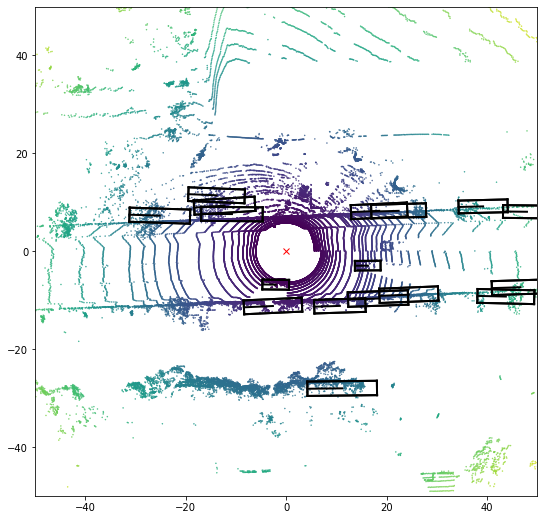

In [26]:
# plotting predicted and ground truth boxes on corresponding lidar point cloud
# pred boxes in lidar's FoR, we get the ground truth boxes in lidar's FoR too.
idx = 0
threshold = 0.7
pred_boxes = get_pred_boxes(pred, threshold, token)
info = token2info[token]
v_path = info["lidar_path"]

points = np.fromfile(v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]
axes_limit = 50
_, ax = plt.subplots(1, 1, figsize=(9, 9))
dists = np.sqrt(np.sum(points[:, :2] ** 2, axis=1))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax.scatter(points[:, 0], points[:, 1], c=colors, s=0.2)
ax.plot(0, 0, "x", color="red")
# Limit visible range.
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)
for pbox in pred_boxes:
#     print(pbox)
    c = np.array(LyftDatasetExplorer.get_color('cone')) / 255.0 # black
    pbox.render(ax, view=np.eye(4), colors=(c, c, c))

In [18]:
info = token2info[token]
v_path = info["lidar_path"]
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]

In [258]:
sample = lyft.get('sample', info['token'])
lidar_token = sample['data']['LIDAR_TOP']
# lyft.render_sample_data(lidar_token)

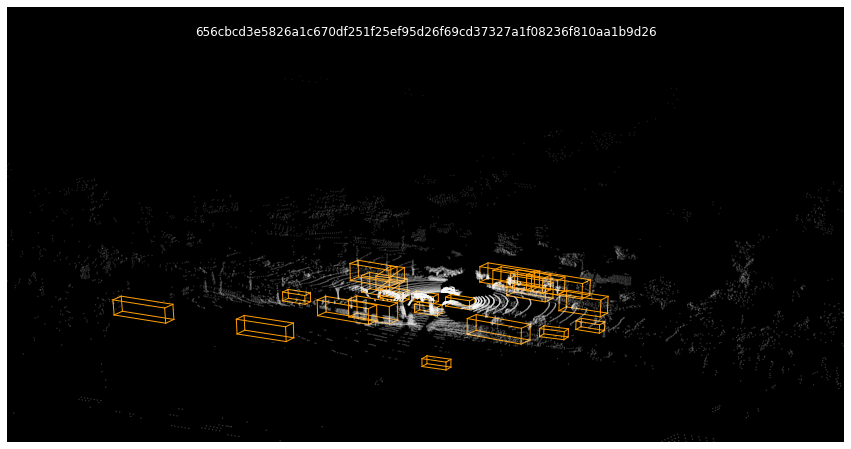

In [259]:
draw_3d_plot(lidar_token, boxes)

In [224]:
def plot_box(box, axis, view, colors, normalize=False, linewidth=1.0):
    '''Plot boxes in the 3d figure'''
    corners = view_points(box.corners(), view, normalize=normalize)#
    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        for corner in selected_corners:
            axis.plot([prev[0], corner[0]], [prev[1], corner[1]], [prev[2], corner[2]], color=color, linewidth=linewidth)
            prev = corner

    # Draw the sides
    for i in range(4):
        axis.plot(
            [corners.T[i][0], corners.T[i + 4][0]],
            [corners.T[i][1], corners.T[i + 4][1]],
            [corners.T[i][2], corners.T[i + 4][2]],
            color=colors[2],
            linewidth=linewidth,
        )

    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0]) #4x3
    draw_rect(corners.T[4:], colors[1])

In [211]:
def draw_3d_plot(lidar_token, boxes):
    '''Plot the lidar + annotations on a 3D figure'''
    # sample lidar point cloud
    lidar_points = get_lidar_points(lidar_token)
    points = 0.5 # fraction of lidar_points to plot, to reduce the clutter
    points_step = int(1. / points)
    pc_range = range(0, lidar_points.shape[1], points_step)
    lidar_points = lidar_points[:, pc_range]
    
    # Get boxes, instead of current sensor's coordinate frame, use vehicle frame which is aligned to z-plane in world
    #_, boxes, _ = lyft.get_sample_data(
    #    lidar_token, flat_vehicle_coordinates=True
    #)
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')                    
    point_size = 0.01 * (1. / points) # size of the dots on plot
    ax.set_facecolor('black')
    ax.grid(False)
    ax.scatter(*lidar_points, s=point_size, c='white', cmap='gray')
    for box in boxes:
        c = np.array(lyft.explorer.get_color(box.name)) / 255.0
        plot_box(box, ax, view=np.eye(3), colors=(c, c, c), linewidth=1)
    ax.set_xlim3d(-40, 40)
    ax.set_ylim3d(-40, 40)
    ax.set_zlim3d(-4, 40)
    
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_title(lidar_token, color='white')
#     filename = 'tmp/frame_{0:0>4}.png'.format(idx)
#     plt.savefig(filename)
#     plt.close(fig)
    plt.show()
#     return filename

In [182]:
def get_lidar_points(lidar_token):
    '''Get lidar point cloud in the frame of the ego vehicle'''
    sd_record = lyft.get("sample_data", lidar_token)
    sensor_modality = sd_record["sensor_modality"]
    
    # Get aggregated point cloud in lidar frame.
    sample_rec = lyft.get("sample", sd_record["sample_token"])
    chan = sd_record["channel"]
    ref_chan = "LIDAR_TOP"
    pc, times = LidarPointCloud.from_file_multisweep(
        lyft, sample_rec, chan, ref_chan, num_sweeps=1
    )
    # Compute transformation matrices for lidar point cloud
    cs_record = lyft.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
    pose_record = lyft.get("ego_pose", sd_record["ego_pose_token"])
    vehicle_from_sensor = np.eye(4)
    vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
    vehicle_from_sensor[:3, 3] = cs_record["translation"]
    
    ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
    rot_vehicle_flat_from_vehicle = np.dot(
        Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
        Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
    )
    vehicle_flat_from_vehicle = np.eye(4)
    vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle
    points = view_points(
        pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
    )
    return points

In [183]:
pc = get_lidar_points(sample['data']['LIDAR_TOP'])

In [123]:
pred.keys()

dict_keys(['box3d_lidar', 'scores', 'label_preds', 'metadata'])

In [ ]:
vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
org_bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(org_bev_map.copy(), vis_point_range, boxes_lidar, [0, 255, 0], 2)

In [28]:
box3d_lidar = pred['box3d_lidar']
scores = pred['scores']
label_preds = pred['label_preds']
metadata = pred['metadata']

In [32]:
box3d_lidar.shape

torch.Size([188, 7])

In [29]:
label_preds

tensor([0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 6, 6, 2, 2, 6, 0, 0, 6, 6, 6, 2, 2,
        6, 6, 6, 6, 6, 6, 0, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6,
        6, 6, 2, 6, 2, 6, 6, 0, 6, 6, 6, 2, 2, 6, 6, 5, 6, 6, 6, 2, 2, 6, 6, 6,
        6, 2, 2, 6, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 6, 0, 6, 2, 6, 2, 6, 2, 6,
        6, 6, 6, 6, 5, 6, 6, 0, 6, 6, 0, 5, 2, 0, 1, 6, 6, 2, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 2, 6, 6, 6, 0, 6, 6, 6, 6, 6, 2, 0, 6, 2, 2, 6, 6, 6, 6, 6, 0,
        0, 6, 6, 6, 2, 6, 6, 0, 2, 5, 0, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 2, 6, 2, 2, 6, 0, 6, 6, 2, 6, 6, 6, 2, 2, 6],
       device='cuda:0')

In [42]:
classes = target_assigner.classes

In [45]:

classes = target_assigner.classes
preds = [classes[x] for x in label_preds]
preds

['car',
 'car',
 'car',
 'car',
 'car',
 'bus',
 'bus',
 'bus',
 'car',
 'bus',
 'bus',
 'bus',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'car',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'car',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'car',


In [ ]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

In [ ]:
img_id = train.iloc[0]['Id']
ps = train.iloc[0]['PredictionString']
ps = ps.split()
objects = [ps[x:x+8] for x in range(0, len(ps), 8)]
len(objects), objects[0]

In [285]:
train.iloc[0]['PredictionString']

'2680.2830359778527 698.1969292852777 -18.04776692365821 2.064 5.488 2.053 2.6041643845397946 car 2691.997461646401 660.8016536569899 -18.674258695658377 1.818 4.57 1.608 -0.33517602468486984 car 2713.6075009338388 694.4034809694599 -18.589971933264334 1.779 4.992 1.62 2.579455758321168 car 2679.986916931015 706.9101495091695 -18.349594424165822 1.798 3.903 1.722 2.5861656766206993 car 2659.352095715659 719.4174623706303 -18.442998898501283 1.936 4.427 1.921 2.601798964714126 car 2705.199576267366 687.6053718669459 -18.13608710950738 1.849 4.586 1.801 2.6187666817281556 car 2712.706309822551 690.895857094069 -18.43179693610965 1.848 4.829 1.528 2.571936879901208 car 2755.5551865955817 646.2995181065994 -18.04141609089024 2.003 5.109 1.875 -0.5583518579067484 car 2721.868054568993 685.1596225679214 -17.64155351660436 2.539 7.671 3.287 2.609719767554756 truck 2723.602359479293 680.1666687198758 -17.298964332024624 2.557 7.637 3.594 2.598576712925146 truck 2683.980215118377 712.4764240778